# Jack Gibson

#  Cluster 3

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import subprocess
import sys
def install_and_import(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install_and_import('statsmodels')
import statsmodels.api as sm
import joblib
import os

In [3]:
# Load in Cluster 3 DataFrame
df = pd.read_csv("df_cluster_3.csv")
df.head()

,ROA(C) before interest and depreciation before interest,Operating Expense Rate,Long-term Liability to Current Assets,Inventory/Current Liability,Total expense/Assets,Long-term fund suitability ratio (A),Inventory Turnover Rate (times),Current Asset Turnover Rate,Revenue per person,Research and development expense rate,...,Operating Gross Margin,Cash flow rate,Average Collection Days,Degree of Financial Leverage (DFL),Accounts Receivable Turnover,Net Value Growth Rate,Realized Sales Gross Profit Growth Rate,Cluster,Bankrupt?,Index
0,0.392352,-0.710177,-0.222917,-0.145766,-0.392842,-0.575125,-0.862115,-0.470892,-0.088753,0.523112,...,-0.152473,-0.161158,0.546835,-0.114306,-0.210941,-0.020065,-0.028139,3,0,1
1,1.087478,-0.710176,-0.032264,-0.140612,-0.406193,-0.484462,-0.862114,-0.470872,-0.314012,0.926047,...,0.249774,0.302571,0.334909,-0.106063,-0.197537,-0.002216,-0.007537,3,0,2
2,-1.037170,-0.710171,-0.006962,-0.301385,0.384654,0.600422,-0.862066,-0.470906,0.860122,1.007838,...,-0.562958,-0.776154,-0.356984,-0.199463,-0.102001,-0.204765,-0.114938,3,0,11
3,1.412776,1.410420,-0.270475,-0.101057,-1.396106,-0.684253,-0.862101,-0.470875,-0.692356,0.796215,...,0.196214,2.912489,-0.213531,-0.119558,-0.134067,-0.149719,-0.104854,3,0,13
4,-0.993582,-0.710165,-0.184728,-0.132542,1.118243,-0.763779,1.220717,-0.470909,-0.370211,1.022770,...,-0.420115,-0.127495,-0.252045,-0.175986,-0.126497,-0.223163,-0.118146,3,0,15


# reduce the number of features by running OLS and only keeping significant features 


In [4]:

X = df.drop(columns=['Cluster','Bankrupt?',"Index"])
y = df["Bankrupt?"].values
X_with_const = sm.add_constant(X)

#f OLS model
ols = sm.OLS(y, X_with_const).fit()

#print(ols.summary())

Reduce our number of features to only keep those with a p-value of less than 0.01.

In [13]:
pvals = ols.pvalues
pvals = pvals.drop("const")

#keep only features with p-value < 0.001
selected_features = pvals[pvals < 0.001].index.tolist()

print(f"Selected {len(selected_features)} features:\n", selected_features)
X_selected = X[selected_features]

Selected 5 features:
 [' Total expense/Assets', ' Revenue Per Share (Yuan ¥)', ' Current Liabilities/Liability', ' Total debt/Total net worth', ' Degree of Financial Leverage (DFL)']


Before running our stacked model, we will see how each base model performs individually. 

Training accuracy (meta-model): 0.999

Number of features used: 5


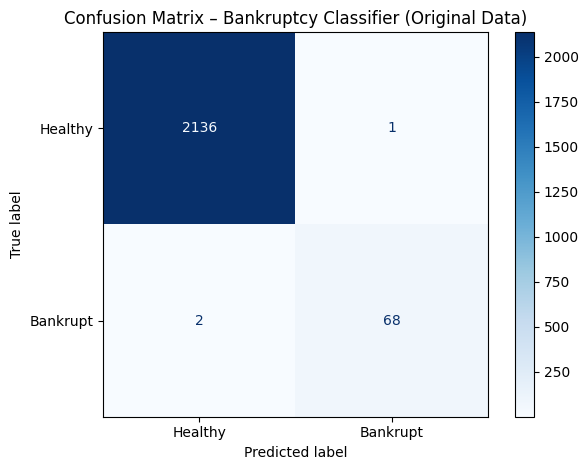

In [14]:
# --- base learners ---
base_learners = [
    ('svc', SVC(kernel='rbf', C=5, probability=True,class_weight='balanced', random_state=42)),
    ('dt', DecisionTreeClassifier(max_depth=20, class_weight='balanced', random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42))
]

# --- meta learner ---
meta_learner = MLPClassifier(
    hidden_layer_sizes=(50,), activation='relu', max_iter=500, random_state=42
)


# --- stacking model ---
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=10,      
    passthrough=False    
)

# --- fit stacking model directly on original X_selected, y ---
stacking_clf.fit(X_selected, y)

# --- get training accuracy (for Table 3) ---
train_acc_meta = stacking_clf.score(X_selected, y)
print(f"Training accuracy (meta-model): {train_acc_meta:.3f}")

# --- get number of features ---
n_features_used = X_selected.shape[1]
print(f"\nNumber of features used: {n_features_used}")

# predict on the full training data
y_pred_full = stacking_clf.predict(X_selected)

# plot confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y, y_pred_full,
    display_labels=["Healthy", "Bankrupt"],
    cmap="Blues", values_format="d"
)
plt.title("Confusion Matrix – Bankruptcy Classifier (Original Data)")
plt.tight_layout()
plt.show()



# PRINT ACCURACY_SCORE[TT(TF)] FOR META MODEL


In [15]:
acc = accuracy_score(y, y_pred_full)

# Compute TT (true bankrupt predicted bankrupt) and TF (false bankrupt predicted healthy)
TT = ((y == 1) & (y_pred_full == 1)).sum()  # True Bankrupt predicted as Bankrupt
TF = ((y == 1) & (y_pred_full == 0)).sum()  # True Bankrupt predicted as Healthy

# Print final output in your desired format
print(f"\nAccuracy (Meta Model) [TT(TF)]: {acc:.3f} [{TT}({TF})]")


Accuracy (Meta Model) [TT(TF)]: 0.999 [68(2)]


Now we will calculate and print the base models' individual accuracies, cumulative average accuracies, and print the confusion matrix.

Training accuracy (SVC): 0.927 [70(162)]


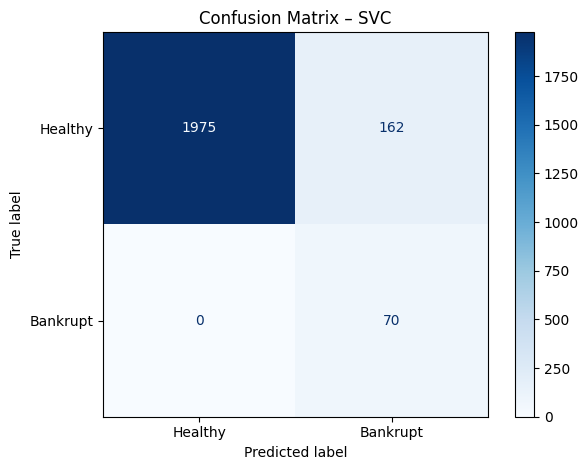

Training accuracy (Decision Tree): 1.000 [70(0)]


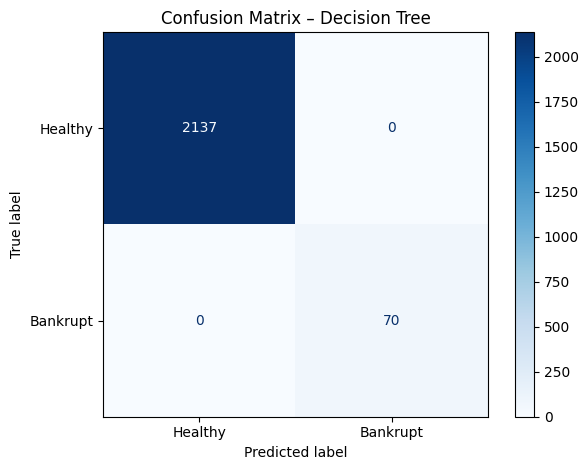

Training accuracy (Random Forest): 1.000 [70(0)]


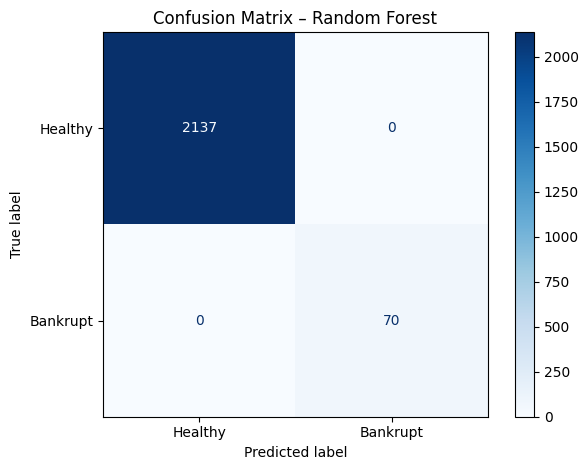


Average training accuracy of base models: 0.976
Average TT(TF): 70.0(54.0)


In [16]:
# calc and print base models' average Accuracy score and [TT(TF)]

base_model_accuracies = []
base_model_TT = []
base_model_TF = []

def evaluate_model(model, X, y, model_name):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    base_model_accuracies.append(acc)
    base_model_TT.append(tp)
    base_model_TF.append(fp)
    
    print(f"Training accuracy ({model_name}): {acc:.3f} [{tp}({fp})]")
    
    # Plot confusion matrix
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Bankrupt"]).plot(cmap="Blues")
    plt.title(f"Confusion Matrix – {model_name}")
    plt.tight_layout()
    plt.show()

# --- evaluate each base model ---
evaluate_model(stacking_clf.named_estimators_['svc'], X_selected, y, 'SVC')
evaluate_model(stacking_clf.named_estimators_['dt'], X_selected, y, 'Decision Tree')
evaluate_model(stacking_clf.named_estimators_['rf'], X_selected, y, 'Random Forest')

# --- compute and print average accuracy ---
avg_base_acc = np.mean(base_model_accuracies)
print(f"\nAverage training accuracy of base models: {avg_base_acc:.3f}")

avg_TT = np.mean(base_model_TT)
avg_TF = np.mean(base_model_TF)
print(f"Average TT(TF): {avg_TT:.1f}({avg_TF:.1f})")

In [19]:
# Save Cluster 3 data

new_train_df = df[[" Total expense/Assets", " Revenue Per Share (Yuan ¥)", 
                   " Current Liabilities/Liability", " Total debt/Total net worth", 
                   " Degree of Financial Leverage (DFL)", "Cluster", "Bankrupt?", "Index"]]

os.makedirs("saved_models", exist_ok=True)

# --- 1. Save the trained stacking model ---
joblib.dump(stacking_clf, "saved_models/cluster3_stacking_model.joblib")
print("Successfully saved stacking model to saved_models/cluster3_stacking_model.joblib")

# --- 2. Save the list of selected features used in training ---
joblib.dump(new_train_df, "saved_models/cluster3_train_data.joblib")
print(" Successfully saved selected features to saved_models/cluster3_train_data.joblib")

Successfully saved stacking model to saved_models/cluster3_stacking_model.joblib
 Successfully saved selected features to saved_models/cluster3_train_data.joblib
